In [1]:
import pandas as pd
import numpy as np
import re
import os

In [3]:
# --- 1. Upload CSV for grid ---
# grid_file = st.file_uploader("Upload Rebate Grid CSV", type=["csv"])
# if grid_file:
    # grid_df = pd.read_csv(grid_file)
    # st.subheader("📋 Uploaded Rebate Grid")
grid_df = pd.read_csv(rf"C:\Users\750040697\OneDrive - Genpact\Documents\REBATE_SIMULATOR\REBATE_SIMULATOR\program_grid.csv")

# --- 2. Parse bins and rates ---
# Extract volume bins from first column
volume_bins = []
for row in grid_df.iloc[:, 0]:
    if "+" in str(row):
        lower = float(re.findall(r'\d+', str(row))[0])
        volume_bins.append((lower, np.inf))
    else:
        nums = re.findall(r'\d+', str(row))
        lower, upper = map(float, nums)
        volume_bins.append((lower, upper))

# Extract growth bins from column headers
growth_bins = [float(x) for x in grid_df.columns[1:]]
growth_bins.append(np.inf)

# Build rate dictionary
volume_labels = [f"V{i+1}" for i in range(len(volume_bins))]
growth_labels = [f"G{i+1}" for i in range(len(growth_bins)-1)]

rebate_rates = {}
for i, v_label in enumerate(volume_labels):
    for j, g_label in enumerate(growth_labels):
        rebate_rates[(v_label, g_label)] = float(grid_df.iloc[i, j+1])

# else:
#     st.warning("Upload a CSV to get started.")
#     st.stop()



# --- 4. Assign tiers dynamically ---
def assign_tiers_from_bins(df, volume_bins, growth_bins):
    v_edges = [b[0] for b in volume_bins] + [volume_bins[-1][1]]  # Build numeric edges
    v_labels = [f"V{i+1}" for i in range(len(volume_bins))]
    g_labels = [f"G{i+1}" for i in range(len(growth_bins)-1)]

    df = df.copy()
    df["growth"] = (df["curryr_rev"] - df["prevyr_rev"]) / df["prevyr_rev"]
    # 3. Assign tiers using curryr_rev for volume and calculated growth for growth
    df["volume_tier"] = pd.cut(df["curryr_rev"], bins=v_edges, labels=v_labels, right=True)
    df["growth_tier"] = pd.cut(df["growth"], bins=growth_bins, labels=g_labels, right=False)
    # 4. Optionally keep rfp_group and rfp_name for downstream grouping
    df = df[["rfp_group", "rfp_name", "curryr_rev", "prevyr_rev", "growth", "volume_tier", "growth_tier"]]
    return df

In [4]:
df = pd.read_csv(rf"C:\Users\750040697\OneDrive - Genpact\Documents\REBATE_SIMULATOR\REBATE_SIMULATOR\DummyDataGpot2.csv").rename(columns=str.lower)
df = assign_tiers_from_bins(df, volume_bins, growth_bins)

    # --- 5. Compute rebates ---
def compute_rebate_rate(row):
        return rebate_rates.get((row["volume_tier"], row["growth_tier"]), 0) 
def compute_rebate(row):
        return rebate_rates.get((row["volume_tier"], row["growth_tier"]), 0) * row["curryr_rev"]
df["rebate_rate"] = df.apply(compute_rebate_rate, axis=1)
df["rebate"] = df.apply(compute_rebate, axis=1)

In [5]:
df.to_csv(rf"C:\Users\750040697\OneDrive - Genpact\Documents\REBATE_SIMULATOR\REBATE_SIMULATOR\DummyDataGpot2.csv", index=False )

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# === Function to generate monotonic grid ===
def generate_monotonic_grid(volume_bins, growth_bins):
    num_volumes = len(volume_bins)
    num_growths = len(growth_bins)
    grid = np.zeros((num_volumes, num_growths))
    
    min_rate = 0.01
    max_rate = 0.15
    
    for i in range(num_volumes):
        for j in range(num_growths):
            if growth_bins[j][1] <= 0.08:  # No rebate tier
                grid[i, j] = 0.00
            else:
                if i == 0 and j == 1:
                    rate = min_rate  # Lowest non-zero rebate
                else:
                    prev_vol_rate = grid[i-1, j] if i > 0 else min_rate
                    prev_growth_rate = grid[i, j-1] if j > 0 else min_rate
                    base_rate = max(prev_vol_rate, prev_growth_rate)
                    rate = min(base_rate + np.random.uniform(0.01, 0.03), max_rate)
                    if j == num_growths - 1:
                        # Ensure last growth tier > previous growth tier
                        rate = min(max(grid[i, j-1] + 0.01, rate), max_rate)
                grid[i, j] = round(rate, 2)
    
    df_grid = pd.DataFrame(
        grid,
        columns=[f"{round(g[0], 2)}-{round(g[1], 2) if g[1] != np.inf else 'inf'}" for g in growth_bins],
        index=[f"{int(v[0])}-{int(v[1])}" if v[1] != np.inf else f"{int(v[0])}+" for v in volume_bins]
    ).reset_index().rename(columns={"index": "Volume Bin"})
    
    return df_grid

# === Assign tiers ===
def assign_tiers_from_bins(df, volume_bins, growth_bins):
    v_edges = [b[0] for b in volume_bins] + [volume_bins[-1][1]]
    g_edges = [g[0] for g in growth_bins] + [growth_bins[-1][1]]
    v_labels = [f"V{i+1}" for i in range(len(volume_bins))]
    g_labels = [f"G{i+1}" for i in range(len(growth_bins))]
    df = df.copy()
    df["growth"] = (df["curryr_rev"] - df["prevyr_rev"]) / df["prevyr_rev"]
    df["volume_tier"] = pd.cut(df["curryr_rev"], bins=v_edges, labels=v_labels, right=True)
    df["growth_tier"] = pd.cut(df["growth"], bins=g_edges, labels=g_labels, right=False)
    return df

# === Compute rebate ===
def compute_rebate(row, rebate_rates):
    return rebate_rates.get((row["volume_tier"], row["growth_tier"]), 0) * row["curryr_rev"]



In [20]:

# === Multiple bin configurations ===
bin_configs = [
    {
        "volume_bins": [(5000, 15000), (15000, 30000), (30000, 50000), (50000, np.inf)],
        "growth_bins": [(0.00, 0.08), (0.08, 0.15), (0.15, 0.20), (0.20, np.inf)]
    },
    {
        "volume_bins": [(7000, 20000), (20000, 35000), (35000, 50000), (50000, np.inf)],
        "growth_bins": [(0.00, 0.08), (0.08, 0.12), (0.12, 0.18), (0.18, np.inf)]
    },
    {
        "volume_bins": [(10000, 20000), (20000, 40000), (40000, 50000), (50000, np.inf)],
        "growth_bins": [(0.00, 0.08), (0.08, 0.14), (0.14, 0.20), (0.20, np.inf)]
    }
]

# === Simulation parameters ===
num_iterations = 50
overall_best_rev = -np.inf
overall_best_grid = None
overall_best_config = None

In [21]:
# Paths
os.makedirs("grids", exist_ok=True)
data_file = r"L:\NASales\03_RFP\20_RFP-Finance\REBATE_SIMULATOR\DummyDataGpot2.csv"

# Load base data
df_base = pd.read_csv(data_file).rename(columns=str.lower)

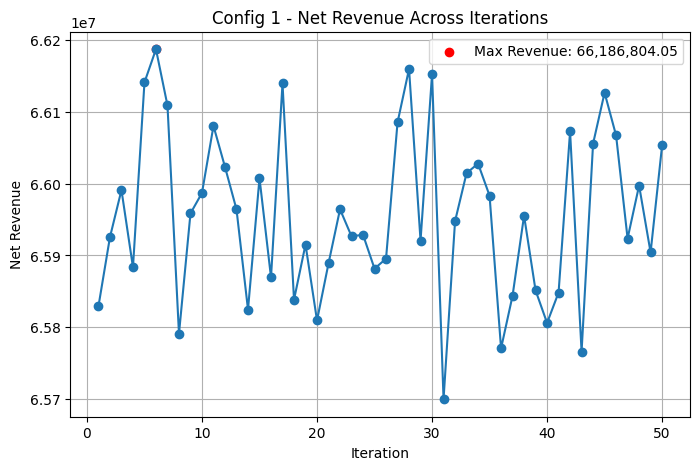


📊 Config 1 Max Revenue: 66,186,804.05 (Iteration 6)
    Volume Bin  0.0-0.08  0.08-0.15  0.15-0.2  0.2-inf
0   5000-15000       0.0       0.01      0.03     0.04
1  15000-30000       0.0       0.03      0.04     0.05
2  30000-50000       0.0       0.05      0.07     0.09
3       50000+       0.0       0.07      0.09     0.11


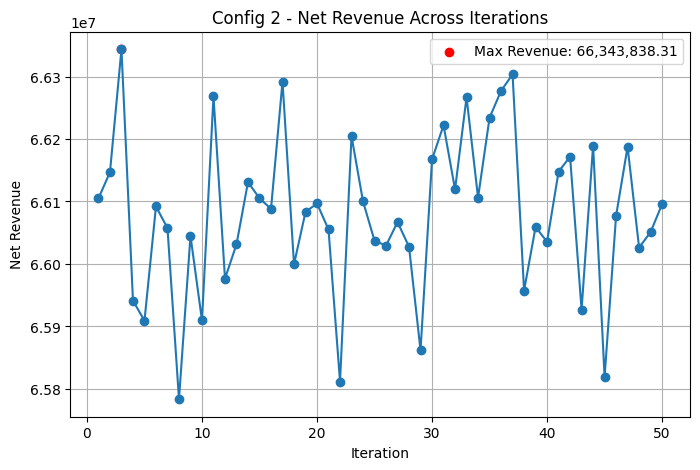


📊 Config 2 Max Revenue: 66,343,838.31 (Iteration 3)
    Volume Bin  0.0-0.08  0.08-0.12  0.12-0.18  0.18-inf
0   7000-20000       0.0       0.01       0.02      0.03
1  20000-35000       0.0       0.02       0.04      0.06
2  35000-50000       0.0       0.04       0.06      0.08
3       50000+       0.0       0.06       0.09      0.11


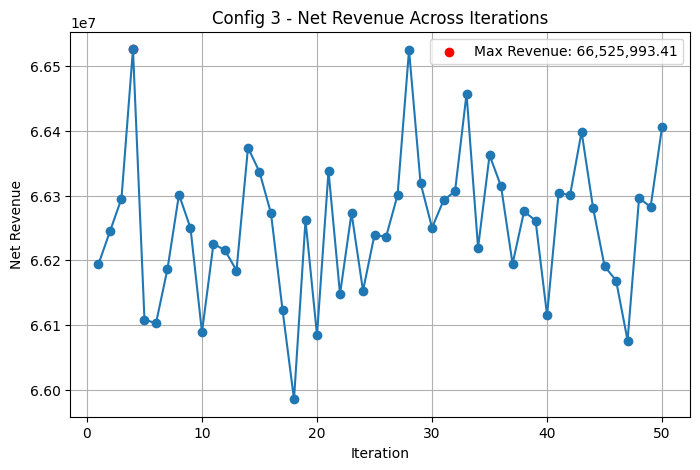


📊 Config 3 Max Revenue: 66,525,993.41 (Iteration 4)
    Volume Bin  0.0-0.08  0.08-0.14  0.14-0.2  0.2-inf
0  10000-20000       0.0       0.01      0.02     0.03
1  20000-40000       0.0       0.02      0.04     0.06
2  40000-50000       0.0       0.03      0.06     0.08
3       50000+       0.0       0.05      0.07     0.10

🏆 Overall Best Config:
{'volume_bins': [(10000, 20000), (20000, 40000), (40000, 50000), (50000, inf)], 'growth_bins': [(0.0, 0.08), (0.08, 0.14), (0.14, 0.2), (0.2, inf)]}

🏅 Overall Best Grid Table:
    Volume Bin  0.0-0.08  0.08-0.14  0.14-0.2  0.2-inf
0  10000-20000       0.0       0.01      0.02     0.03
1  20000-40000       0.0       0.02      0.04     0.06
2  40000-50000       0.0       0.03      0.06     0.08
3       50000+       0.0       0.05      0.07     0.10

✅ Overall Max Revenue: 66,525,993.41


In [22]:


# === Loop over configs ===
for config_index, config in enumerate(bin_configs, start=1):
    volume_bins = config["volume_bins"]
    growth_bins = config["growth_bins"]
    
    revenues = []
    best_net_revenue = -np.inf
    best_grid_df = None
    best_iter = None
    
    for iteration in range(1, num_iterations + 1):
        grid_df = generate_monotonic_grid(volume_bins, growth_bins)
        grid_path = f"grids/config{config_index}_grid_{iteration}.csv"
        grid_df.to_csv(grid_path, index=False)
        
        volume_labels = [f"V{i+1}" for i in range(len(volume_bins))]
        growth_labels = [f"G{i+1}" for i in range(len(growth_bins))]
        rebate_rates = {(v, g): float(grid_df.iloc[i, j+1]) for i, v in enumerate(volume_labels) for j, g in enumerate(growth_labels)}
        
        df = assign_tiers_from_bins(df_base, volume_bins, growth_bins)
        df["rebate"] = df.apply(lambda row: compute_rebate(row, rebate_rates), axis=1)
        
        net_revenue = df["curryr_rev"].sum() - df["rebate"].sum()
        revenues.append(net_revenue)
        
        if net_revenue > best_net_revenue:
            best_net_revenue = net_revenue
            best_grid_df = grid_df.copy()
            best_iter = iteration
    
    # Plot for this config
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_iterations + 1), revenues, marker='o')
    plt.scatter(best_iter, best_net_revenue, color='red', label=f"Max Revenue: {best_net_revenue:,.2f}")
    plt.title(f"Config {config_index} - Net Revenue Across Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Net Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"\n📊 Config {config_index} Max Revenue: {best_net_revenue:,.2f} (Iteration {best_iter})")
    print(best_grid_df)
    
    # Track overall best
    if best_net_revenue > overall_best_rev:
        overall_best_rev = best_net_revenue
        overall_best_grid = best_grid_df.copy()
        overall_best_config = config

# === Show overall best config + grid ===
print("\n🏆 Overall Best Config:")
print(overall_best_config)
print("\n🏅 Overall Best Grid Table:")
print(overall_best_grid)
print(f"\n✅ Overall Max Revenue: {overall_best_rev:,.2f}")


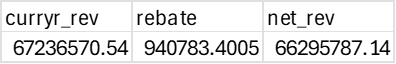


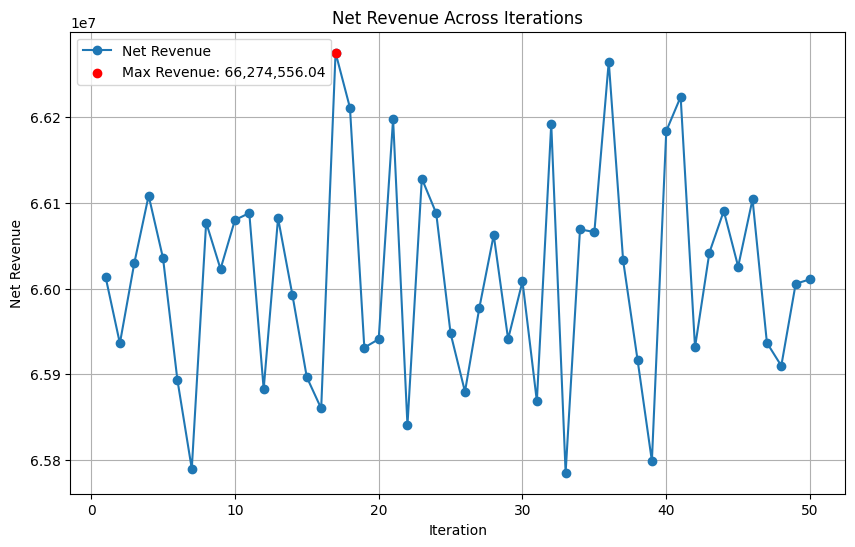


✅ Max Net Revenue: 66,274,556.04 at Iteration 17
📄 Best Grid File: grids/grid_17.csv

🏆 Best Grid Table:

    Volume Bin  0.0-0.08  0.08-0.15  0.15-0.2  0.2-inf
0   5000-15000       0.0       0.01      0.03     0.04
1  15000-30000       0.0       0.02      0.04     0.05
2  30000-50000       0.0       0.04      0.05     0.07
3       50000+       0.0       0.07      0.08     0.10


In [17]:
# === Plot Net Revenue per Iteration ===
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), revenues, marker='o', label="Net Revenue")
max_iter = revenues.index(best_net_revenue) + 1
plt.scatter(max_iter, best_net_revenue, color='red', zorder=5, label=f"Max Revenue: {best_net_revenue:,.2f}")
plt.title("Net Revenue Across Iterations")
plt.xlabel("Iteration")
plt.ylabel("Net Revenue")
plt.legend()
plt.grid(True)
plt.show()

# === Display Best Grid Table ===
print(f"\n✅ Max Net Revenue: {best_net_revenue:,.2f} at Iteration {max_iter}")
print(f"📄 Best Grid File: {best_grid_file}")
print("\n🏆 Best Grid Table:\n")
print(best_grid_df)